# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the NMNIST dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import tonic, torch, os
%cd ../hots
from utils import get_loader, get_dataset_info
from utils import make_histogram_classification, HOTS_Dataset
from network import network
from timesurface import timesurface

print(f' Tonic version installed -> {tonic.__version__}')

transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform)
#get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(dataset)}')

/home/antoine/homhots/hotsline/hots
 Tonic version installed -> 1.0.15
number of samples in the dataset: 60000


In [10]:
import matplotlib.pyplot as plt

def plot_accuracy(scores, parameters, ind_param):
    paramlist = ['number of layers', 'R', 'tau', 'number of neurons']
    fig, ax = plt.subplots(figsize=(10,6))
    score_previous = 0
    for ind in range(len(scores)):
        score, tau = scores[ind], parameters[ind][ind_param]
        ax.plot(tau, score, '*', color='blue')
        ax.set_xlabel(paramlist[ind_param])
        ax.set_ylabel('accuracy')
        if score>score_previous:
            score_previous=score
            parameters_previous=parameters[ind]
    print(score_previous, parameters_previous)

In [11]:
def plot_accuracy_multi_param(scores, parameters):
    fig = plt.figure(figsize=(30,10))
    sub1 = fig.add_subplot(1,3,1, projection="3d")
    sub2 = fig.add_subplot(1,3,2, projection="3d")
    sub3 = fig.add_subplot(1,3,3, projection="3d")
    score_previous = 0
    colormap = plt.cm.get_cmap('summer_r', 10);
    for ind in range(len(scores)):
        score, lay, n_neuron, R = scores[ind], parameters[ind][0], parameters[ind][3], parameters[ind][1]
        sub1.scatter(n_neuron, lay, score, color=colormap(R/4), alpha=0.5)
        sub2.scatter(R, lay, score, color=colormap(n_neuron/16), alpha=0.5)
        sub3.scatter(n_neuron, R, score, color=colormap(lay/4), alpha=0.5)
        sub1.set_xlabel('neuron number')
        sub2.set_xlabel('R')
        sub3.set_xlabel('neuron number')
        sub1.set_ylabel('layer number')
        sub2.set_ylabel('layer number')
        sub3.set_ylabel('R')
        #sub1.view_init(10,-40)

In [5]:
plot_accuracy_multi_param(scores, parameters)

NameError: name 'scores' is not defined

0.85625 [2, 2, 10000.0, 16]


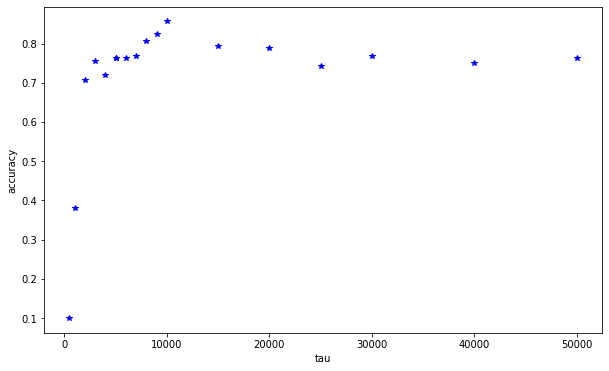

In [13]:
plot_accuracy(scores, parameters, 2)

In [14]:
N_layers = [1]
for lay in N_layers:
    print(lay)

1


## Parameter tuning

In [7]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform, first_saccade_only=True)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=transform, first_saccade_only=True)

name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

R_first = (2, 4)
N_layers = (2,3)#,4)
n_first = (4,8,16)
tau_first = (.5e3,1e3,2e3,3e3,4e3,5e3,5e3,6e3,7e3,8e3,9e3)#,1e4)

tau = 8e3

parameters = []
scores = []

for lay in N_layers:
    for R in R_first:
        #for tau in tau_first:
        for N_neuron in n_first:
            Rz = [R*2**Nl for Nl in range(lay)]
            N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
            N_pola = N_neuronz.copy()
            N_pola.insert(0,2)
            tauz = [tau*N_pola[Nl+1]/N_pola[Nl] for Nl in range(lay-1)]
            tauz.insert(0,tau*2)
            hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
            filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
            #clustering
            loader = get_loader(trainset, kfold = 300)
            hots.clustering(loader, trainset.ordering, filtering_threshold)
            #training
            loader = get_loader(trainset, kfold = 60)
            num_sample_train = len(loader)
            hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
            #testing
            loader = get_loader(testset, kfold = 60)
            num_sample_test = len(loader)
            hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
            jitter = (None, None)

            train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
            test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

            testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
            trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

            score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
            print(f' Accuracy: {score*100}%')

            parameters.append([lay, R, tau, N_neuron])
            scores.append(score)

  0%|█▏                                                                                                                                                                                                                                       | 1/200 [00:04<14:05,  4.25s/it]


KeyboardInterrupt: 

In [12]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform, first_saccade_only=True)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=transform, first_saccade_only=True)

name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

tau_first = (.5e3,1e3,2e3,3e3,4e3,5e3,5e3,6e3,7e3,8e3,9e3,1e4,15e3,2e4,25e3,3e4,4e4,5e4)

parameters = []
scores = []

tau = 1e4
lay = 2
R = 2
N_neuron = 16
for tau in tau_first:
        Rz = [R*2**Nl for Nl in range(lay)]
        N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
        N_pola = N_neuronz.copy()
        N_pola.insert(0,2)
        tauz = [tau*N_pola[Nl+1]/N_pola[Nl] for Nl in range(lay-1)]
        tauz.insert(0,tau*2)
        hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
        filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
        #clustering
        loader = get_loader(trainset, kfold = 300)
        hots.clustering(loader, trainset.ordering, filtering_threshold)
        #training
        loader = get_loader(trainset, kfold = 60)
        num_sample_train = len(loader)
        hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
        #testing
        loader = get_loader(testset, kfold = 60)
        num_sample_test = len(loader)
        hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
        jitter = (None, None)

        train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
        test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

        testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
        trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

        score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
        print(f' Accuracy: {score*100}%')

        parameters.append([lay, R, tau, N_neuron])
        scores.append(score)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 672.44it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[2000.0, 8000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[2000.0, 8000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 658.92it/s]


 Accuracy: 38.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[4000.0, 16000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[4000.0, 16000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 659.63it/s]


 Accuracy: 70.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[6000.0, 24000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[6000.0, 24000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 680.34it/s]


 Accuracy: 75.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[8000.0, 32000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[8000.0, 32000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 675.64it/s]


 Accuracy: 71.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 696.97it/s]


 Accuracy: 76.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 675.60it/s]


 Accuracy: 76.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[12000.0, 48000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[12000.0, 48000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 668.42it/s]


 Accuracy: 76.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[14000.0, 56000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[14000.0, 56000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 672.69it/s]


 Accuracy: 76.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[16000.0, 64000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[16000.0, 64000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 672.13it/s]


 Accuracy: 80.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[18000.0, 72000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[18000.0, 72000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 667.05it/s]


 Accuracy: 82.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[20000.0, 80000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[20000.0, 80000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 643.87it/s]


 Accuracy: 85.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[30000.0, 120000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[30000.0, 120000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 661.82it/s]


 Accuracy: 79.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[40000.0, 160000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[40000.0, 160000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 665.96it/s]


 Accuracy: 78.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[50000.0, 200000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[50000.0, 200000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 669.59it/s]


 Accuracy: 74.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[60000.0, 240000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[60000.0, 240000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 666.19it/s]


 Accuracy: 76.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[80000.0, 320000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[80000.0, 320000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 669.44it/s]


 Accuracy: 75.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[100000.0, 400000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[100000.0, 400000.0]_[2, 4]_160_(None, None)/
['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two'] ['4 - four', '9 - nine', '0 - zero', '1 - one', '5 - five', '6 - six', '8 - eight', '7 - seven', '3 - three', '2 - two']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 668.39it/s]

 Accuracy: 76.25%


### Choice of an architecture
Initial choice is to have an increased number of neurons with 3 layers. 

In [ ]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

Rz = (2, 4)
N_neuronz = (8, 16)
tauz = (5e3, 5e3*8/2)

network = network(name, dataset_name, timestr, dataset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

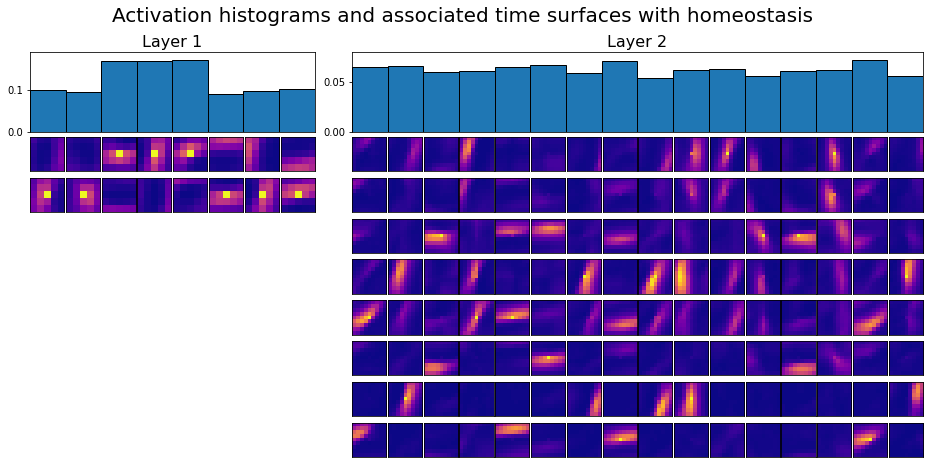

In [14]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+network.name+'.pkl'
if not os.path.exists(path):
    network.clustering(loader, dataset.ordering, filtering_threshold)
network.plotlayers();

In [9]:
loader = get_loader(dataset, kfold = None, shuffle=True)
num_sample_train = len(dataset)
network.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=True)

TypeError: coding() missing 1 required positional argument: 'filtering_threshold'

In [ ]:
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
num_sample_test = len(dataset)
loader = get_loader(dataset, kfold = None, shuffle=True)
network.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=False)

In [ ]:
from utils import make_histogram_classification, HOTS_Dataset
jitter = (None, None)

train_path = f'../Records/output/train/{network.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{network.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
trainset = HOTS_Dataset(train_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

In [ ]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1]) 
print(f' Accuracy: {score*100}%')